In [43]:
import os
fullpth = os.path.abspath(os.path.curdir)
while os.path.basename(os.path.abspath(os.path.curdir)) != 'multi-instance-mask-rcnn-extension':
    %cd ../
from multimaskextension.train.script_utils import DETECTRON_REPO

In [48]:
## Customizable here!

impath = "./data/datasets/custom/singleimg_nephews_wrestle/images/nephews.png"
modelzoo_config_filepath = f"{DETECTRON_REPO}/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
modelzoo_model_rel_path = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

checkpoint = "output/logs/train/summer2021/train_2021-06-21-162041_VCS-375c9c4_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/model_checkpoints/model_064000.pth.tar"
cfg_is_deprecated = True
deprecated_keys = ['MODEL.ROI_MASK_HEAD.WEIGHTS_RANDOM_INIT_PRIMARY', 'MODEL.ROI_MASK_HEAD.WEIGHTS_RANDOM_INIT_SECONDARY']


In [3]:
from PIL import Image
import numpy as np

def read_image(impath, fmt):
    image = Image.open(impath)

    if fmt is not None:
        # PIL only supports RGB, so convert to RGB and flip channels over below
        conversion_format = fmt
        if fmt == "BGR":
            conversion_format = "RGB"
        image = image.convert(conversion_format)
    image = np.asarray(image)
    if fmt == "BGR":
        # flip channels if needed
        image = image[:, :, ::-1]
    # PIL squeezes out the channel dimension for "L", so make it HWC
    if fmt == "L":
        image = np.expand_dims(image, -1)
    return image

# image = predictor.transform_gen.get_transform(original_image).apply_image(original_image)



Exported /home/adelgior/workspace/images/000001_input.png


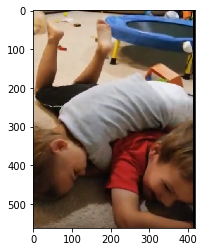

In [4]:
%matplotlib inline
import cv2
from multimaskextension.analysis.vis_utils import plt_imshow, FigExporter

img = read_image(impath, fmt='RGB')
img = img.copy()
plt_imshow(img)
exporter = FigExporter()
exporter.cv2_imwrite(img, 'input')


In [12]:
## Pure inference
%matplotlib inline
from multimaskextension.train.script_utils import get_cfg, download_detectron_model_to_local_zoo, DETECTRON_REPO
from detectron2.engine import DefaultPredictor
import matplotlib.pyplot as plt

cfg = get_cfg()
cfg.merge_from_file(config_filepath)
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the
# following shorthand
local_path = download_detectron_model_to_local_zoo(model_rel_path)
cfg.MODEL.WEIGHTS = local_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
predictor = DefaultPredictor(cfg)
# c. Get Mask R-CNN predictions and print boxes
outputs = predictor(img)  # predictor wants BGR and will handle flipping if model wants RGB

from pprint import pprint
pprint(outputs["instances"].pred_classes)
pprint(outputs["instances"].pred_boxes)

# d. Visualize and export Mask R-CNN predictions
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2.0)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow()
imout = v.get_image()[:, :, ::-1]
exporter.cv2_imwrite(imout, 'predictions_modelzoo')
# plt.imshow(v.get_image()[:,:,::-1])
# exporter.export_gcf('prediction')

tensor([ 0,  0, 65], device='cuda:0')
Boxes(tensor([[ 28.2714,  41.2056, 417.8725, 551.2443],
        [176.2999, 241.2552, 415.9345, 555.9039],
        [385.2069,  79.8023, 412.3253, 110.2844]], device='cuda:0'))
Exported /home/adelgior/workspace/images/000009_predictions_modelzoo.png


In [13]:
import yaml
from multimaskextension.train import script_utils

if cfg_is_deprecated:
    # Handle deprecated cfg
    config_filepath = "output/logs/train/summer2021/train_2021-06-21-162041_VCS-375c9c4_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/config.yaml"
    deprecated_config_filepath = config_filepath
    cfg_deprecated = yaml.safe_load(open(deprecated_config_filepath, 'rb'))
    for k in deprecated_keys:
        v = cfg_deprecated
        for kitr in k.split('.'):
            lastv = v
            v = v[kitr]
        print('Removed', k, ': ', v)
        del lastv[kitr]
    upgraded_config_filepath = deprecated_config_filepath.replace('.yaml', '-upgraded.yaml')
    yaml.dump(cfg_deprecated, open(upgraded_config_filepath, 'w'))
    cfg_upgraded = yaml.safe_load(open(upgraded_config_filepath, 'rb'))
cfg = script_utils.get_custom_maskrcnn_cfg(upgraded_config_filepath, weights_checkpoint=checkpoint)


Removed MODEL.ROI_MASK_HEAD.WEIGHTS_RANDOM_INIT_PRIMARY :  True
Removed MODEL.ROI_MASK_HEAD.WEIGHTS_RANDOM_INIT_SECONDARY :  True


In [14]:
## Load mymodel

# Don't know how to avoid importing this
# noinspection PyUnresolvedReferences
from multimaskextension.model import multi_roi_heads_apd
# noinspection PyUnresolvedReferences
from multimaskextension.data import registryextension
from multimaskextension.train import trainer_apd
import torch

cpu = False

config_filepath = upgraded_config_filepath
cfg = script_utils.get_custom_maskrcnn_cfg(config_filepath, weights_checkpoint=checkpoint)
mymodel = trainer_apd.Trainer_APD.build_model(cfg)
print('Loading state dict')
state = torch.load(checkpoint, map_location=torch.device('cpu')) if cpu \
    else torch.load(checkpoint)
mymodel.load_state_dict(state['model_state_dict'])


Loading state dict


<All keys matched successfully>

Exported /home/adelgior/workspace/images/000010_predictions.png


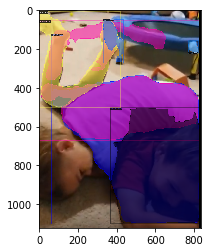

In [15]:
%matplotlib inline
def detach_outputs(outputs):
    for f in outputs['instances']._fields:
        t = getattr(outputs['instances'], f)
        if torch.is_tensor(t):
            if t.requires_grad:
                t = t.detach()
        else:
            if t.tensor.requires_grad:
                t.tensor = t.tensor.detach()
                
import detectron2.data.transforms as T
def get_model_input(original_image):
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    if cfg.INPUT.FORMAT == "RGB":
        # whether the model expects BGR inputs or RGB
        original_image = original_image[:, :, ::-1]
    height, width = original_image.shape[:2]
    image = transform_gen.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image, "height": height, "width": width}
    return inputs

mymodel.eval()
inputs = get_model_input(img)
outputs, proposal_extras = mymodel([inputs], trace_proposals=True)

detach_outputs(outputs[0])

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2.0)
v = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
# cv2_imshow()
exporter.cv2_imwrite(v.get_image()[:, :, ::-1], 'predictions')
# exporter.export_gcf('prediction')
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

In [56]:
modelname = 'cpt_'
from detectron2.evaluation.evaluator import inference_context
cfg = get_cfg()
cfg.merge_from_file(config_filepath)

fmt = cfg.INPUT.FORMAT
img_modelfmt = read_image(impath, fmt=fmt)
height, width = img.shape[:2]
inputs = {"image": torch.as_tensor(img_modelfmt.astype("float32").transpose(2, 0, 1)), 
          "height": height, "width": width}
# inputs = [torch.from_numpy(im)]
model = mymodel
# model = predictor.model
previously_training = model.training
model.eval()
with inference_context(model), torch.no_grad():
    # Get proposals
    images = model.preprocess_image([inputs])
    features = model.backbone(images.tensor)
    proposalss, proposal_lossess = model.proposal_generator(images, features, None)

    # Get instance boxes, masks, and proposal idxs
    outputs, extra_proposal_details = model([inputs], trace_proposals=True)

if previously_training:
    model.train()

all_outputs = {'outputs': outputs,
        'proposalss': proposalss,
        'proposal_lossess': proposal_lossess,
        'extra_proposal_details': extra_proposal_details
        }


Exported /home/adelgior/workspace/images/000068_nephews_proposals.png
Exported /home/adelgior/workspace/images/000069_nephews_proposals_past_thresh.png
Exported /home/adelgior/workspace/images/000070_nephews_selected_proposals.png
Exported /home/adelgior/workspace/images/000071_vis_utils_nephews_prediction.png
Exported /home/adelgior/workspace/images/000072_vis_utils_cptnephews_pred2_prediction.png


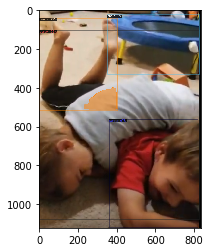

In [57]:
output = all_outputs['outputs'][0]
proposals_pre = all_outputs['proposalss'][0]
visualize_just_image = False
extra_proposal_details = all_outputs['extra_proposal_details'][0]
image_id=os.path.splitext(os.path.basename(impath))[0]
img_prepped, pred_instances, proposals = script_utils.prep_for_visualization(cfg, img, output['instances'], proposals_pre)
output['instances'] = pred_instances
# d. Visualize and export Mask R-CNN predictions
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
proposal_score_thresh = None if model is None else model.roi_heads.test_score_thresh
script_utils.visualize_single_image_output(img_prepped, metadata, pred_instances=output, proposals=proposals, image_id=str(image_id),
                              extra_proposal_details=extra_proposal_details,
                              scale=2.0, proposal_score_thresh=proposal_score_thresh, exporter=exporter,
                              visualize_just_image=visualize_just_image)
## Export secondary masks
if 'pred_masks2' in list(output['instances']._fields.keys()):
    output['instances'].set('pred_masks', output['instances'].pred_masks2)
    img_prepped, pred_instances, proposals = script_utils.prep_for_visualization(cfg, img, output['instances'], proposals_pre)
    output['instances'] = pred_instances
    # d. Visualize and export Mask R-CNN predictions
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    proposal_score_thresh = None if model is None else model.roi_heads.test_score_thresh
    script_utils.visualize_single_image_output(img_prepped, metadata, pred_instances=output, 
        proposals=None, image_id=modelname + str(image_id) + '_pred2', extra_proposal_details=None, scale=2.0, 
        proposal_score_thresh=None, exporter=exporter, visualize_just_image=visualize_just_image)


In [51]:
modelname = 'zoo_'
from detectron2.evaluation.evaluator import inference_context
# For Mask R-CNN, actually wants RGB(?)

cfg_zoo = get_cfg()
cfg_zoo.merge_from_file(modelzoo_config_filepath)
fmt = cfg_zoo.INPUT.FORMAT

# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the
# following shorthand
local_path = download_detectron_model_to_local_zoo(modelzoo_model_rel_path)
cfg_zoo.MODEL.WEIGHTS = local_path
cfg_zoo.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
predictor = DefaultPredictor(cfg_zoo)
model = predictor.model

img_modelfmt = read_image(impath, fmt=fmt)
height, width = img.shape[:2]
inputs = {"image": torch.as_tensor(img_modelfmt.astype("float32").transpose(2, 0, 1)), 
          "height": height, "width": width}
# inputs = [torch.from_numpy(im)]
# model = predictor.model
previously_training = model.training
model.eval()
with inference_context(model), torch.no_grad():
    # Get proposals
    images = model.preprocess_image([inputs])
    features = model.backbone(images.tensor)
    proposalss, proposal_lossess = model.proposal_generator(images, features, None)

    # Get instance boxes, masks, and proposal idxs
    outputs, extra_proposal_details = model([inputs], trace_proposals=True)

if previously_training:
    model.train()

all_outputs = {'outputs': outputs,
        'proposalss': proposalss,
        'proposal_lossess': proposal_lossess,
        'extra_proposal_details': extra_proposal_details
        }


Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Exported /home/adelgior/workspace/images/000064_nephews_proposals.png
Exported /home/adelgior/workspace/images/000065_nephews_proposals_past_thresh.png
Exported /home/adelgior/workspace/images/000066_nephews_selected_proposals.png
Exported /home/adelgior/workspace/images/000067_vis_utils_nephews_prediction.png


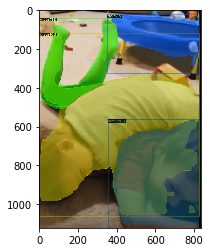

In [54]:
output = all_outputs['outputs'][0]
proposals_pre = all_outputs['proposalss'][0]
visualize_just_image = False
extra_proposal_details = all_outputs['extra_proposal_details'][0]
image_id=os.path.splitext(os.path.basename(impath))[0]
img_prepped, pred_instances, proposals = script_utils.prep_for_visualization(cfg_zoo, img, output['instances'], proposals_pre)
output['instances'] = pred_instances
# d. Visualize and export Mask R-CNN predictions
metadata = MetadataCatalog.get(cfg_zoo.DATASETS.TRAIN[0])
proposal_score_thresh = None if model is None else model.roi_heads.test_score_thresh
script_utils.visualize_single_image_output(img_prepped, metadata, pred_instances=output, proposals=proposals, image_id=str(image_id),
                              extra_proposal_details=extra_proposal_details,
                              scale=2.0, proposal_score_thresh=proposal_score_thresh, exporter=exporter,
                              visualize_just_image=visualize_just_image)
## Export secondary masks
if 'pred_masks2' in list(output['instances']._fields.keys()):
    output['instances'].set('pred_masks', output['instances'].pred_masks2)
    img_prepped, pred_instances, proposals = script_utils.prep_for_visualization(cfg_zoo, img, output['instances'], proposals_pre)
    output['instances'] = pred_instances
    # d. Visualize and export Mask R-CNN predictions
    metadata = MetadataCatalog.get(cfg_zoo.DATASETS.TRAIN[0])
    proposal_score_thresh = None if model is None else model.roi_heads.test_score_thresh
    script_utils.visualize_single_image_output(img_prepped, metadata, pred_instances=output, 
        proposals=None, image_id=modelname + str(image_id) + '_pred2', extra_proposal_details=None, scale=2.0, 
        proposal_score_thresh=None, exporter=exporter, visualize_just_image=visualize_just_image)


In [59]:
%ls output/logs/train

maskrcnninit/
primarysecondaryvsn/
spring2021/
summer2021/
train_2021-10-06-140236_VCS-6ef0df7_MAX_ITR-1000_HEAD_TYPE-None/
train_2021-10-06-141004_VCS-6ef0df7_MAX_ITR-1000_HEAD_TYPE-custom_MATCH-0/
train_2021-10-06-142802_VCS-6ef0df7_MAX_ITR-1000_HEAD_TYPE-custom_MATCH-0/
train_2021-10-07-130419_VCS-6ef0df7_MAX_ITR-5000_HEAD_TYPE-custom_MATCH-0/
train_2021-10-07-130419_VCS-6ef0df7_MAX_ITR-5000_HEAD_TYPE-None/
train_2021-10-07-141749_VCS-6ef0df7_MAX_ITR-2000_HEAD_TYPE-None/
train_2021-10-07-141810_VCS-6ef0df7_MAX_ITR-2000_HEAD_TYPE-None/
train_2021-10-07-141837_VCS-6ef0df7_MAX_ITR-2000_HEAD_TYPE-custom_MATCH-0/
train_2021-10-07-152528_VCS-6ef0df7_MAX_ITR-5000_HEAD_TYPE-None/
train_2021-10-07-152540_VCS-6ef0df7_MAX_ITR-5000_HEAD_TYPE-custom_MATCH-0/
train_2021-10-08-140707_VCS-0d20c2d_MAX_ITR-10000_HEAD_TYPE-custom_MATCH-0/
train_2021-10-08-140707_VCS-0d20c2d_MAX_ITR-10000_HEAD_TYPE-None/
train_2021-10-08-140840_VCS-0d20c2d_MAX_ITR-10000_HEAD_TYPE-None/
train_2021-10-08-141121_VCS-0d20c

In [61]:
%ls 'output/logs/train/train_2021-10-08-142530_VCS-0d20c2d_MAX_ITR-10000_HEAD_TYPE-custom_MATCH-0/model_checkpoints'

model_000000.pth.tar  model_001600.pth.tar  model_006400.pth.tar
model_000100.pth.tar  model_002500.pth.tar  model_008100.pth.tar
model_000400.pth.tar  model_003600.pth.tar
model_000900.pth.tar  model_004900.pth.tar


Loading state dict
Exported /home/adelgior/workspace/images/000083_nephews_proposals.png
Exported /home/adelgior/workspace/images/000084_nephews_proposals_past_thresh.png
Exported /home/adelgior/workspace/images/000085_nephews_selected_proposals.png
Exported /home/adelgior/workspace/images/000086_vis_utils_nephews_prediction.png
Exported /home/adelgior/workspace/images/000087_vis_utils_cptoverfit_nephews_pred2_prediction.png


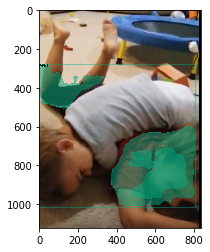

In [73]:
# loading the models overfit to this image in particular

config_filepath = os.path.join("output/logs/train/train_2021-10-07-141837_VCS-6ef0df7_MAX_ITR-2000_HEAD_TYPE-custom_MATCH-0", 'config.yaml')
checkpoint = os.path.join(os.path.dirname(config_filepath), 'model_checkpoints', 'model_001600.pth.tar')
modelname = 'cptoverfit_'
from detectron2.evaluation.evaluator import inference_context
cfg = get_cfg()
cfg.merge_from_file(config_filepath)

mymodel = trainer_apd.Trainer_APD.build_model(cfg)
print('Loading state dict')
state = torch.load(checkpoint, map_location=torch.device('cpu')) if cpu \
    else torch.load(checkpoint)
mymodel.load_state_dict(state['model_state_dict'])

fmt = cfg.INPUT.FORMAT
img_modelfmt = read_image(impath, fmt=fmt)[:,:,::-1]
height, width = img.shape[:2]
inputs = {"image": torch.as_tensor(img_modelfmt.astype("float32").transpose(2, 0, 1)), 
          "height": height, "width": width}
# inputs = [torch.from_numpy(im)]
model = mymodel
# model = predictor.model
previously_training = model.training
model.eval()
with inference_context(model), torch.no_grad():
    # Get proposals
    images = model.preprocess_image([inputs])
    features = model.backbone(images.tensor)
    proposalss, proposal_lossess = model.proposal_generator(images, features, None)

    # Get instance boxes, masks, and proposal idxs
    outputs, extra_proposal_details = model([inputs], trace_proposals=True)

if previously_training:
    model.train()

all_outputs = {'outputs': outputs,
        'proposalss': proposalss,
        'proposal_lossess': proposal_lossess,
        'extra_proposal_details': extra_proposal_details
        }

output = all_outputs['outputs'][0]
proposals_pre = all_outputs['proposalss'][0]
visualize_just_image = False
extra_proposal_details = all_outputs['extra_proposal_details'][0]
image_id=os.path.splitext(os.path.basename(impath))[0]
img_prepped, pred_instances, proposals = script_utils.prep_for_visualization(cfg, img, output['instances'], proposals_pre)
output['instances'] = pred_instances
# d. Visualize and export Mask R-CNN predictions
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
proposal_score_thresh = None if model is None else model.roi_heads.test_score_thresh
script_utils.visualize_single_image_output(img_prepped, metadata, pred_instances=output, proposals=proposals, image_id=str(image_id),
                              extra_proposal_details=extra_proposal_details,
                              scale=2.0, proposal_score_thresh=proposal_score_thresh, exporter=exporter,
                              visualize_just_image=visualize_just_image)
## Export secondary masks
if 'pred_masks2' in list(output['instances']._fields.keys()):
    output['instances'].set('pred_masks', output['instances'].pred_masks2)
    img_prepped, pred_instances, proposals = script_utils.prep_for_visualization(cfg, img, output['instances'], proposals_pre)
    output['instances'] = pred_instances
    # d. Visualize and export Mask R-CNN predictions
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    proposal_score_thresh = None if model is None else model.roi_heads.test_score_thresh
    script_utils.visualize_single_image_output(img_prepped, metadata, pred_instances=output, 
        proposals=None, image_id=modelname + str(image_id) + '_pred2', extra_proposal_details=None, scale=2.0, 
        proposal_score_thresh=None, exporter=exporter, visualize_just_image=visualize_just_image)


In [ ]:
data_loader = Trainer_A.build_test_loader(cfg, dataset_name)
        

In [ ]:
with inference_context(model), torch.no_grad():
    for idx, inputs in tqdm.tqdm(enumerate(data_loader), total=len(data_loader), desc='Testing'):
        if idx == num_warmup:
            start_time = time.time()
            total_compute_time = 0

        start_compute_time = time.time()
        outputs = model(inputs)
